In [287]:
# Clear memory
%reset -f

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [288]:
# System imports
import sys
import importlib
from pathlib import Path

# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Project setup
project_root = Path().resolve().parent
sys.path.append(str(project_root))

# Project modules
MODULES = [
    'iowa_dream.data',
    'iowa_dream.utils',
    'iowa_dream.feature_engineering',
    'iowa_dream.feature_engineering.add_features',
    'iowa_dream.utils.plotting_EDA',
    'iowa_dream.feature_engineering.categotical_transformer',
    'iowa_dream.feature_engineering.numerical_transformer',
]

# Reload modules
for module in MODULES:
    if module in sys.modules:
        importlib.reload(sys.modules[module])
    else:
        __import__(module)

# Project imports
from iowa_dream.data.importer import load_config
from iowa_dream.data.loader import preliminary_loader
from iowa_dream.utils.plotting_EDA import (
    plot_interaction_effects,
    plot_feature_histograms
)

from iowa_dream.feature_engineering.lot_frontage_imputer import *
from iowa_dream.feature_engineering.add_features import *
from iowa_dream.feature_engineering.categotical_transformer import *
from iowa_dream.feature_engineering.numerical_transformer import *

In [289]:
# Example usage
data_file = project_root / load_config()['kaggle']['cleaned_path'] / 'cleaned_AmesHousing.csv'
df = preliminary_loader(data_file)
df.columns

Index(['pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'lot_shape',
       'lot_config', 'neighborhood', 'condition_1', 'overall_qu',
       'overall_cond', 'year_blt', 'year_remod/add', 'roof_style',
       'exterior_1st', 'mas_vnr_type', 'mas_vnr_area', 'exter_cond',
       'foundation', 'bsmt_qu', 'bsmt_cond', 'bsmtfin_sf_1', 'total_bsmt_sf',
       'heating', 'heating_qu', 'electrical', '2nd_flr_sf', 'gr_liv_area',
       'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr',
       'kitchen_qu', 'fireplaces', 'fireplace_qu', 'garage_cars', 'garage_qu',
       'paved_drive', 'wood_deck_sf', 'mo_sold', 'year_sold', 'sale_type',
       'saleprice'],
      dtype='object')

In [290]:
# Get data dictionary from config
config = load_config()
cleaned_data_dict = config['cleaned_data_dict']

# Extract feature groups
ordinal_features = cleaned_data_dict['ordinal']['columns']
nominal_features = cleaned_data_dict['nominal']['columns'] 
discrete_features = cleaned_data_dict['discrete']['columns']
continuous_features = cleaned_data_dict['continuous']['columns']
proximity_data = {
    neighborhood: group['category'] 
    for group in config['university_proximity']
    for neighborhood in group['neighborhoods']
}

# 0. Add new (combined) features 

1. **`total_bath`**  
   Combines `full_bath` and `half_bath` into a single metric, counting half baths as **0.5**. This simplifies the data by consolidating bathroom information into one meaningful numerical feature, which is often more predictive in housing models.

2. **`living_area_percentage`**  
   Represents the ratio of the **above-ground living area** (`gr_liv_area`) to the total available area (including `lot_area`, `total_bsmt_sf`, and decks). This feature gives insight into how efficiently the total property space is being used, which can influence buyer preferences and valuations.

3. **`timing_remodel_index`**  
   Measures the **extent of remodeling** relative to the home's construction age. By normalizing the difference between `year_remod/add` and `year_blt` with the total age of the home, this index highlights homes with recent improvements, which can significantly impact property value.

4. **`university_proximity_category`**  
   Categorizes neighborhoods based on proximity to universities using external data (`proximity_data`). Homes closer to universities are often more valuable due to demand from students and staff, making this a key feature for location-driven pricing.

5. **`neighborhood_score`**  
   Captures the average quality and condition of homes in each neighborhood by combining `overall_qu`, `overall_cond`, and `exter_cond` into a single score. This score is then averaged across neighborhoods, providing a **localized measure of property quality** that models can use to detect neighborhood-specific trends, instead of having 28 dummy variables for neighborhood.

6. **`recession_period`**  
   Flags homes sold in 2007 or later as part of the economic downturn (`1` for recession, `0` otherwise). This feature is critical for understanding market behavior during periods of economic instability, as housing prices may drop or stagnate. This captures meaningful information about the market condition at the time of sale, that is not captured by the `timing_remodel_index`.

7. **`bsmt_total_score`**  
   Combines `bsmt_qu` (basement quality) and `bsmt_cond` (basement condition) into one score. Basements are important for property value, and aggregating their quality and condition creates a more informative, unified feature.

In [291]:
# Transform data with new features
add_drop = Add_Drop_Attributes(proximity_data=proximity_data)
df_transformed = add_drop.fit_transform(df)

In [292]:
final_data_dict = config['final_data_dict']
final_ordinal_features = final_data_dict['ordinal']['columns']
final_nominal_features = final_data_dict['nominal']['columns'] 
final_discrete_features = final_data_dict['discrete']['columns']
final_continuous_features = final_data_dict['continuous']['columns']

# 1. Grouping of infrequent ordinal categories

In [293]:
df_transformed.columns

Index(['pid', 'ms_subclass', 'lot_frontage', 'lot_area', 'lot_shape',
       'lot_config', 'condition_1', 'year_blt', 'roof_style', 'exterior_1st',
       'mas_vnr_type', 'mas_vnr_area', 'exter_cond', 'foundation',
       'bsmtfin_sf_1', 'total_bsmt_sf', 'heating', 'heating_qu', 'electrical',
       '2nd_flr_sf', 'gr_liv_area', 'bedroom_abvgr', 'garage_cars',
       'garage_qu', 'paved_drive', 'wood_deck_sf', 'mo_sold', 'sale_type',
       'saleprice', 'total_bath', 'living_area_percentage',
       'kitchen_quality_score', 'fire_place_score', 'timing_remodel_index',
       'recession_period', 'university_proximity_category',
       'neighborhood_score', 'bsmt_total_score', 'overall_score'],
      dtype='object')

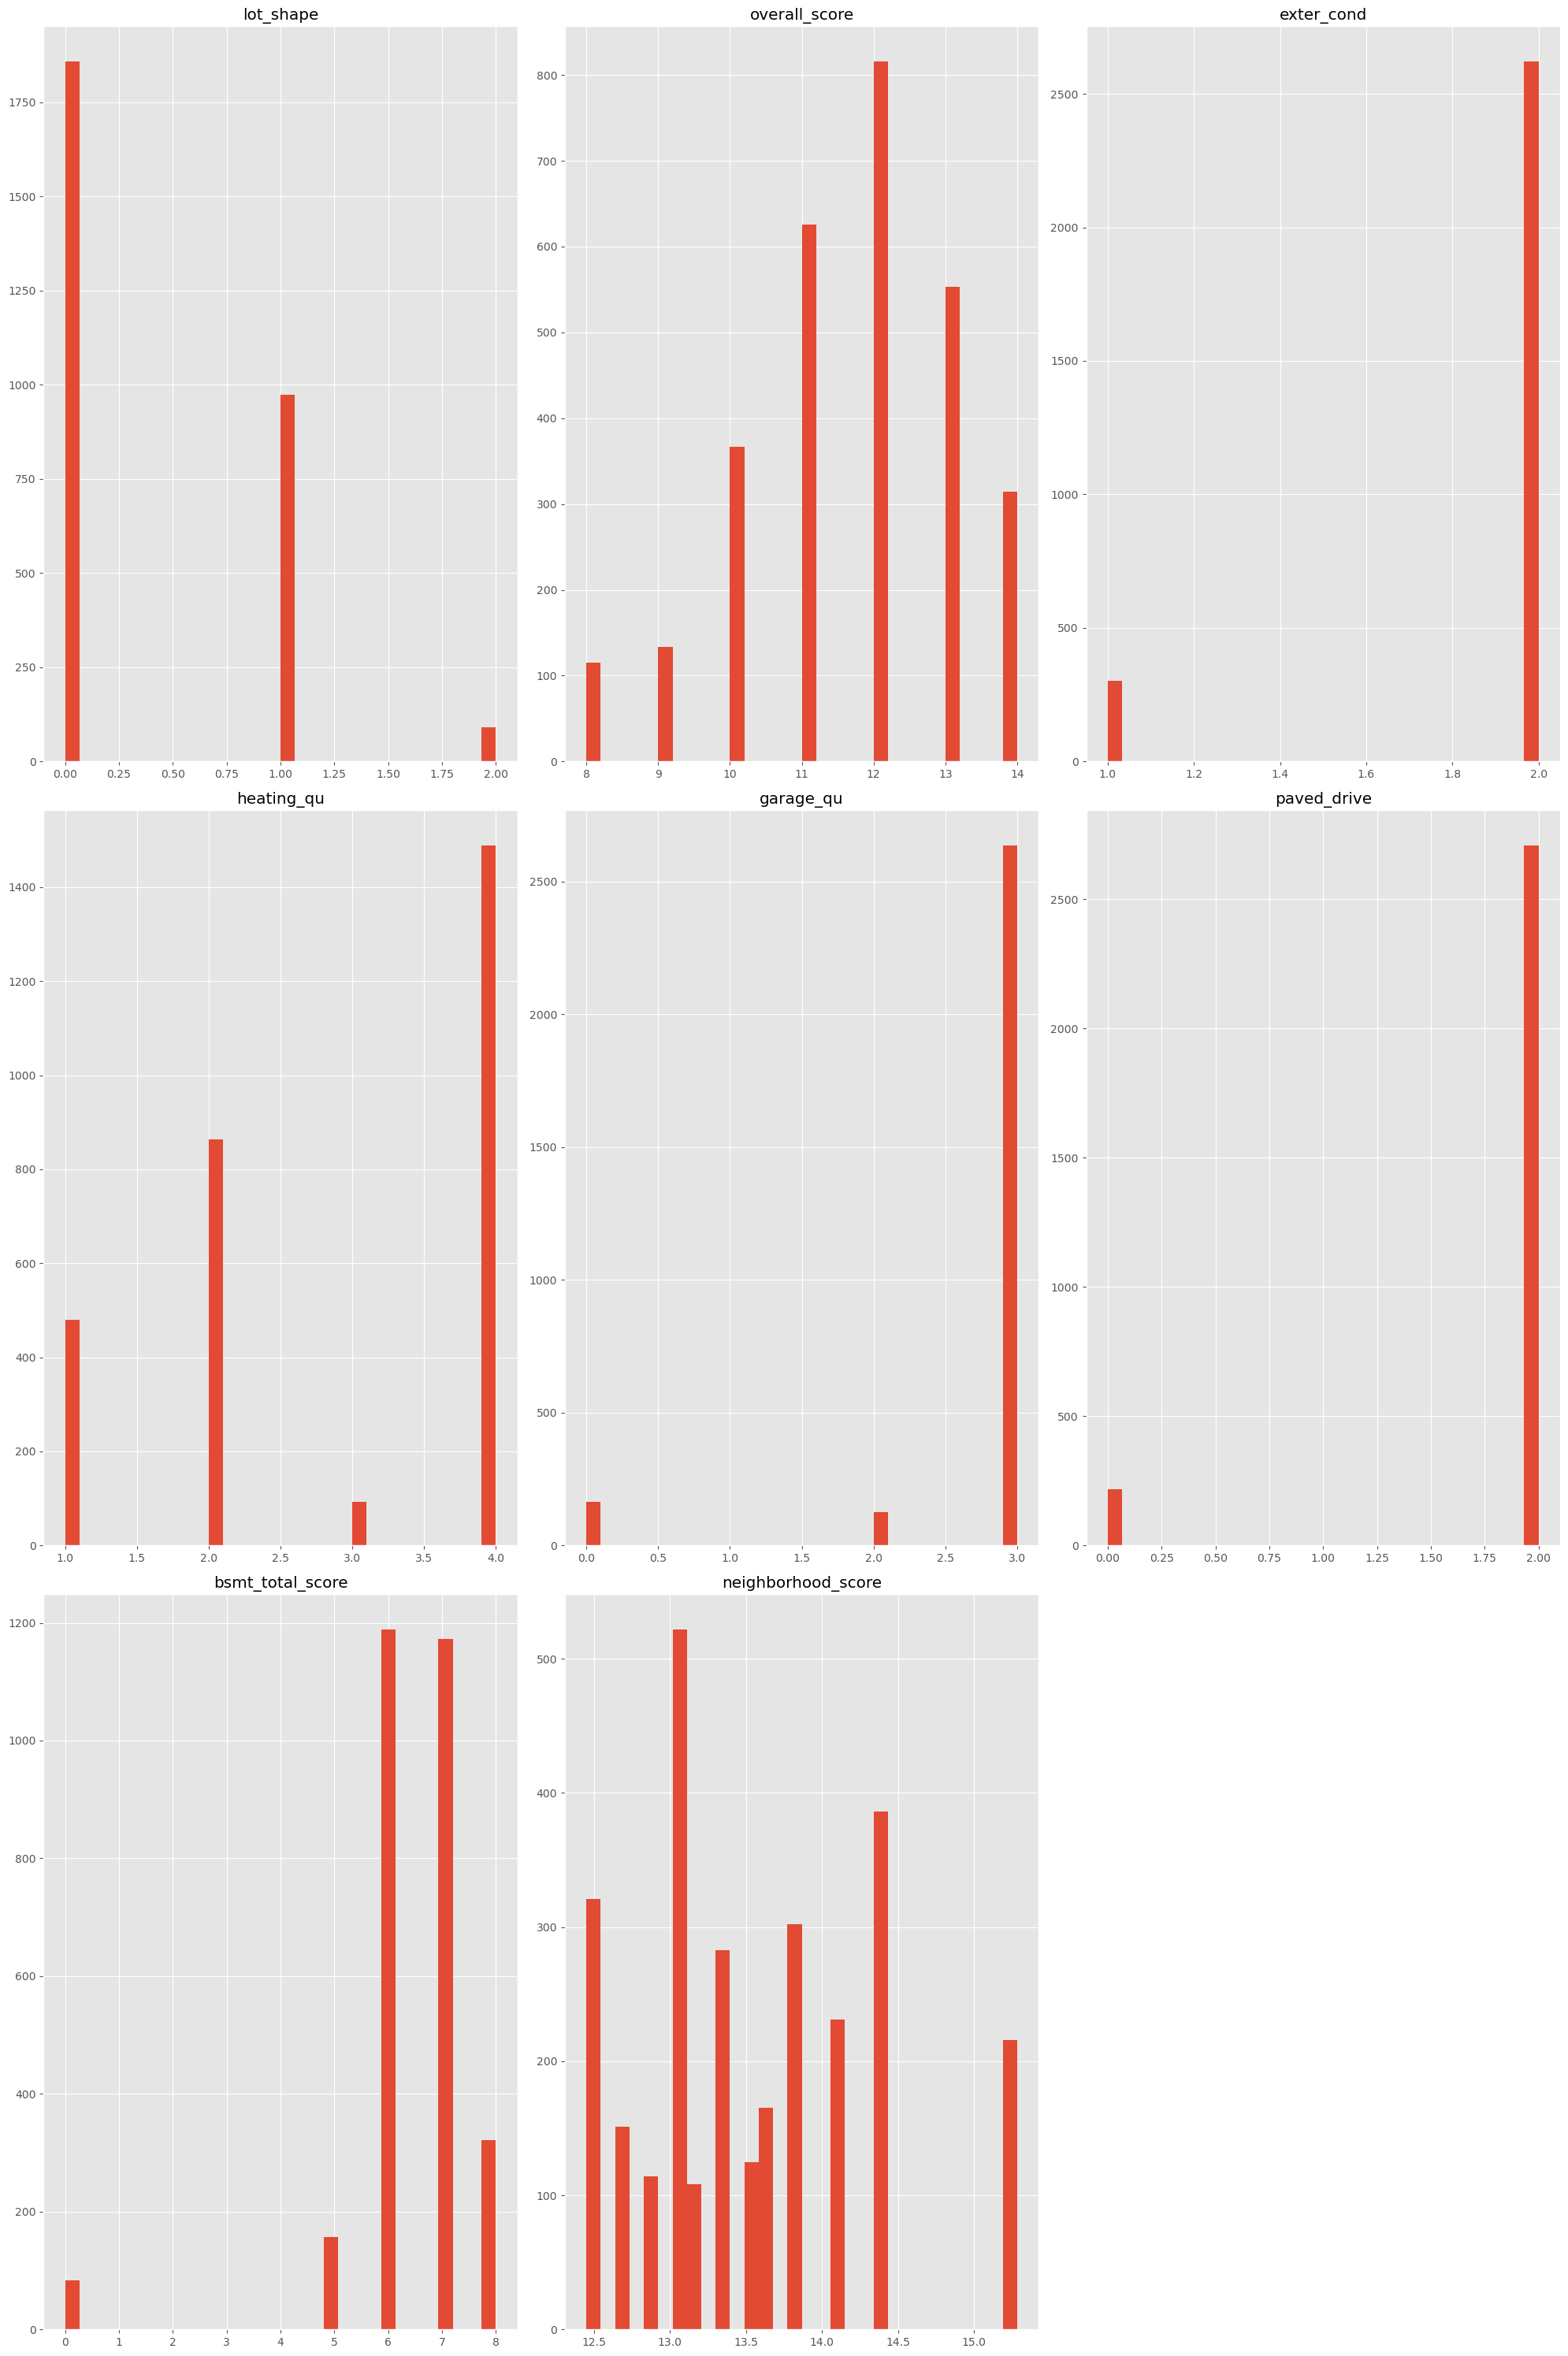

In [294]:
# Create and fit OrdinalMerger for ordinal features
min_obs = int(0.025 * len(df_transformed))  # 2.5% of data
ordinal_merger = OrdinalMerger(min_obs=min_obs)
df_transformed_ordinal = df_transformed[final_ordinal_features]
df_transformed_ordinal_merged = ordinal_merger.fit_transform(df_transformed_ordinal)

plot_feature_histograms(df_transformed_ordinal_merged)

In [295]:
for col in final_ordinal_features:
    df_transformed[col] = df_transformed_ordinal_merged[col]

# 2. Grouping of infrequent nominal categories

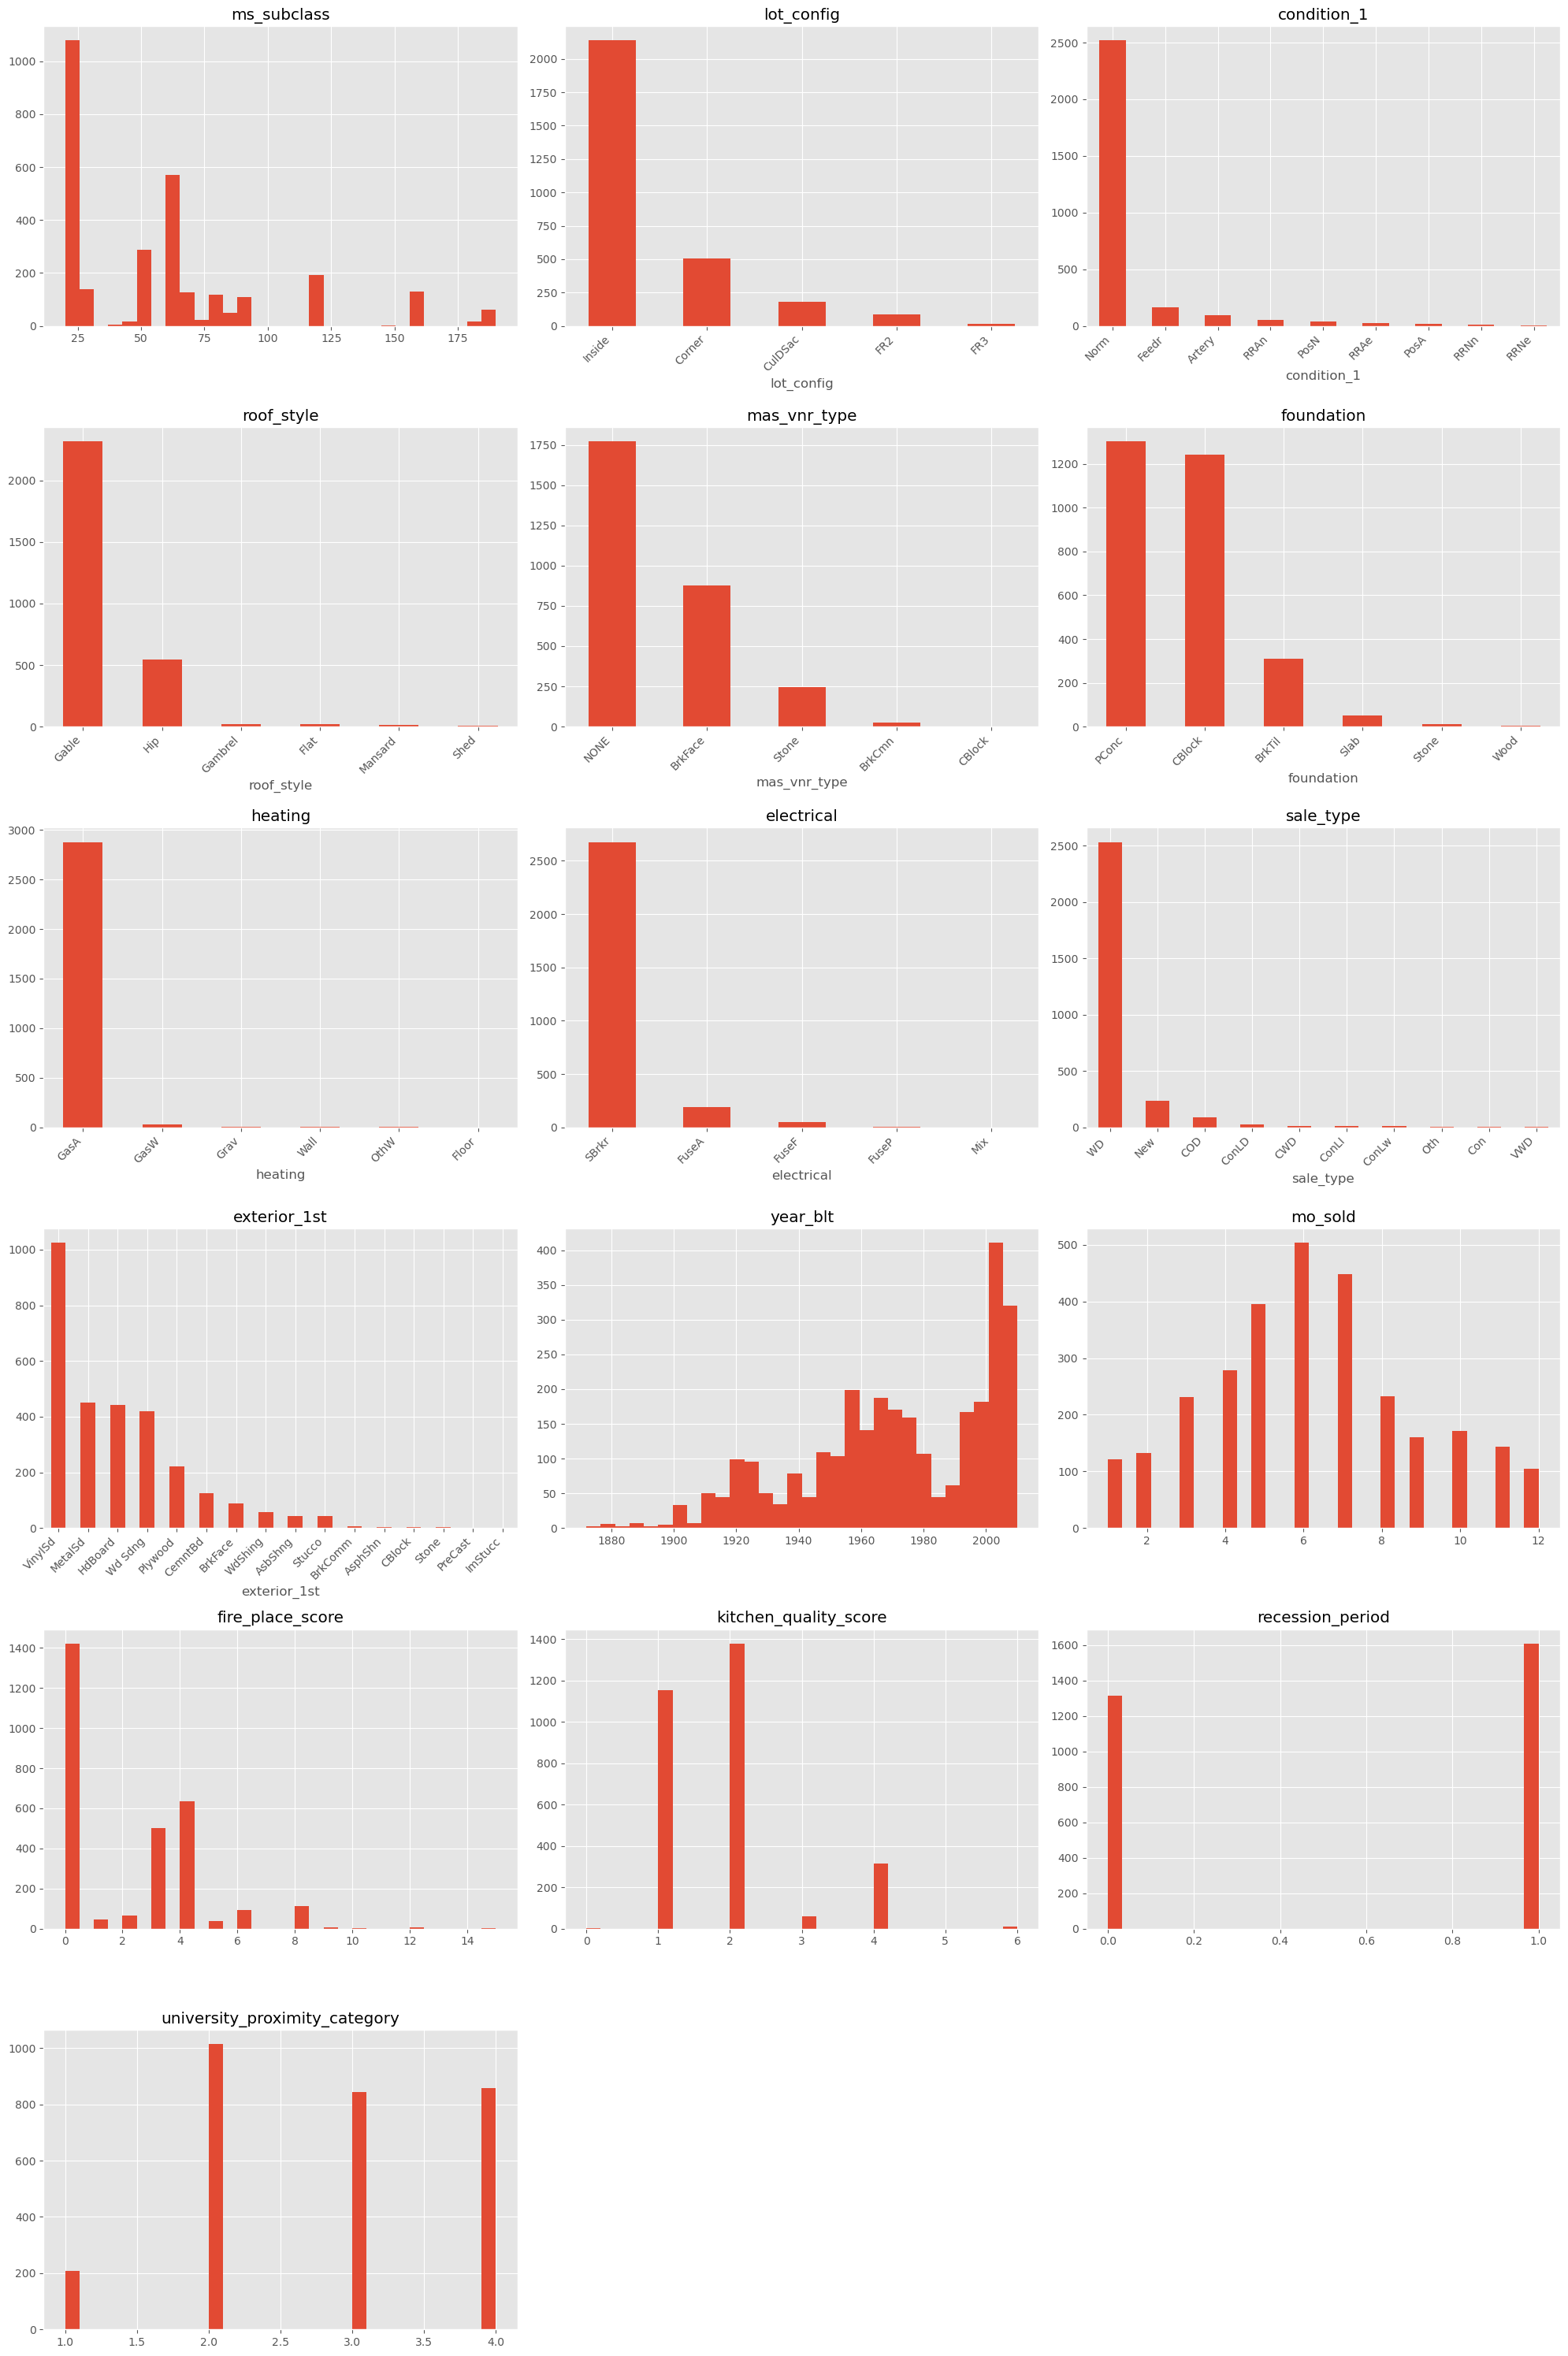

In [296]:
plot_feature_histograms(df_transformed[final_nominal_features])

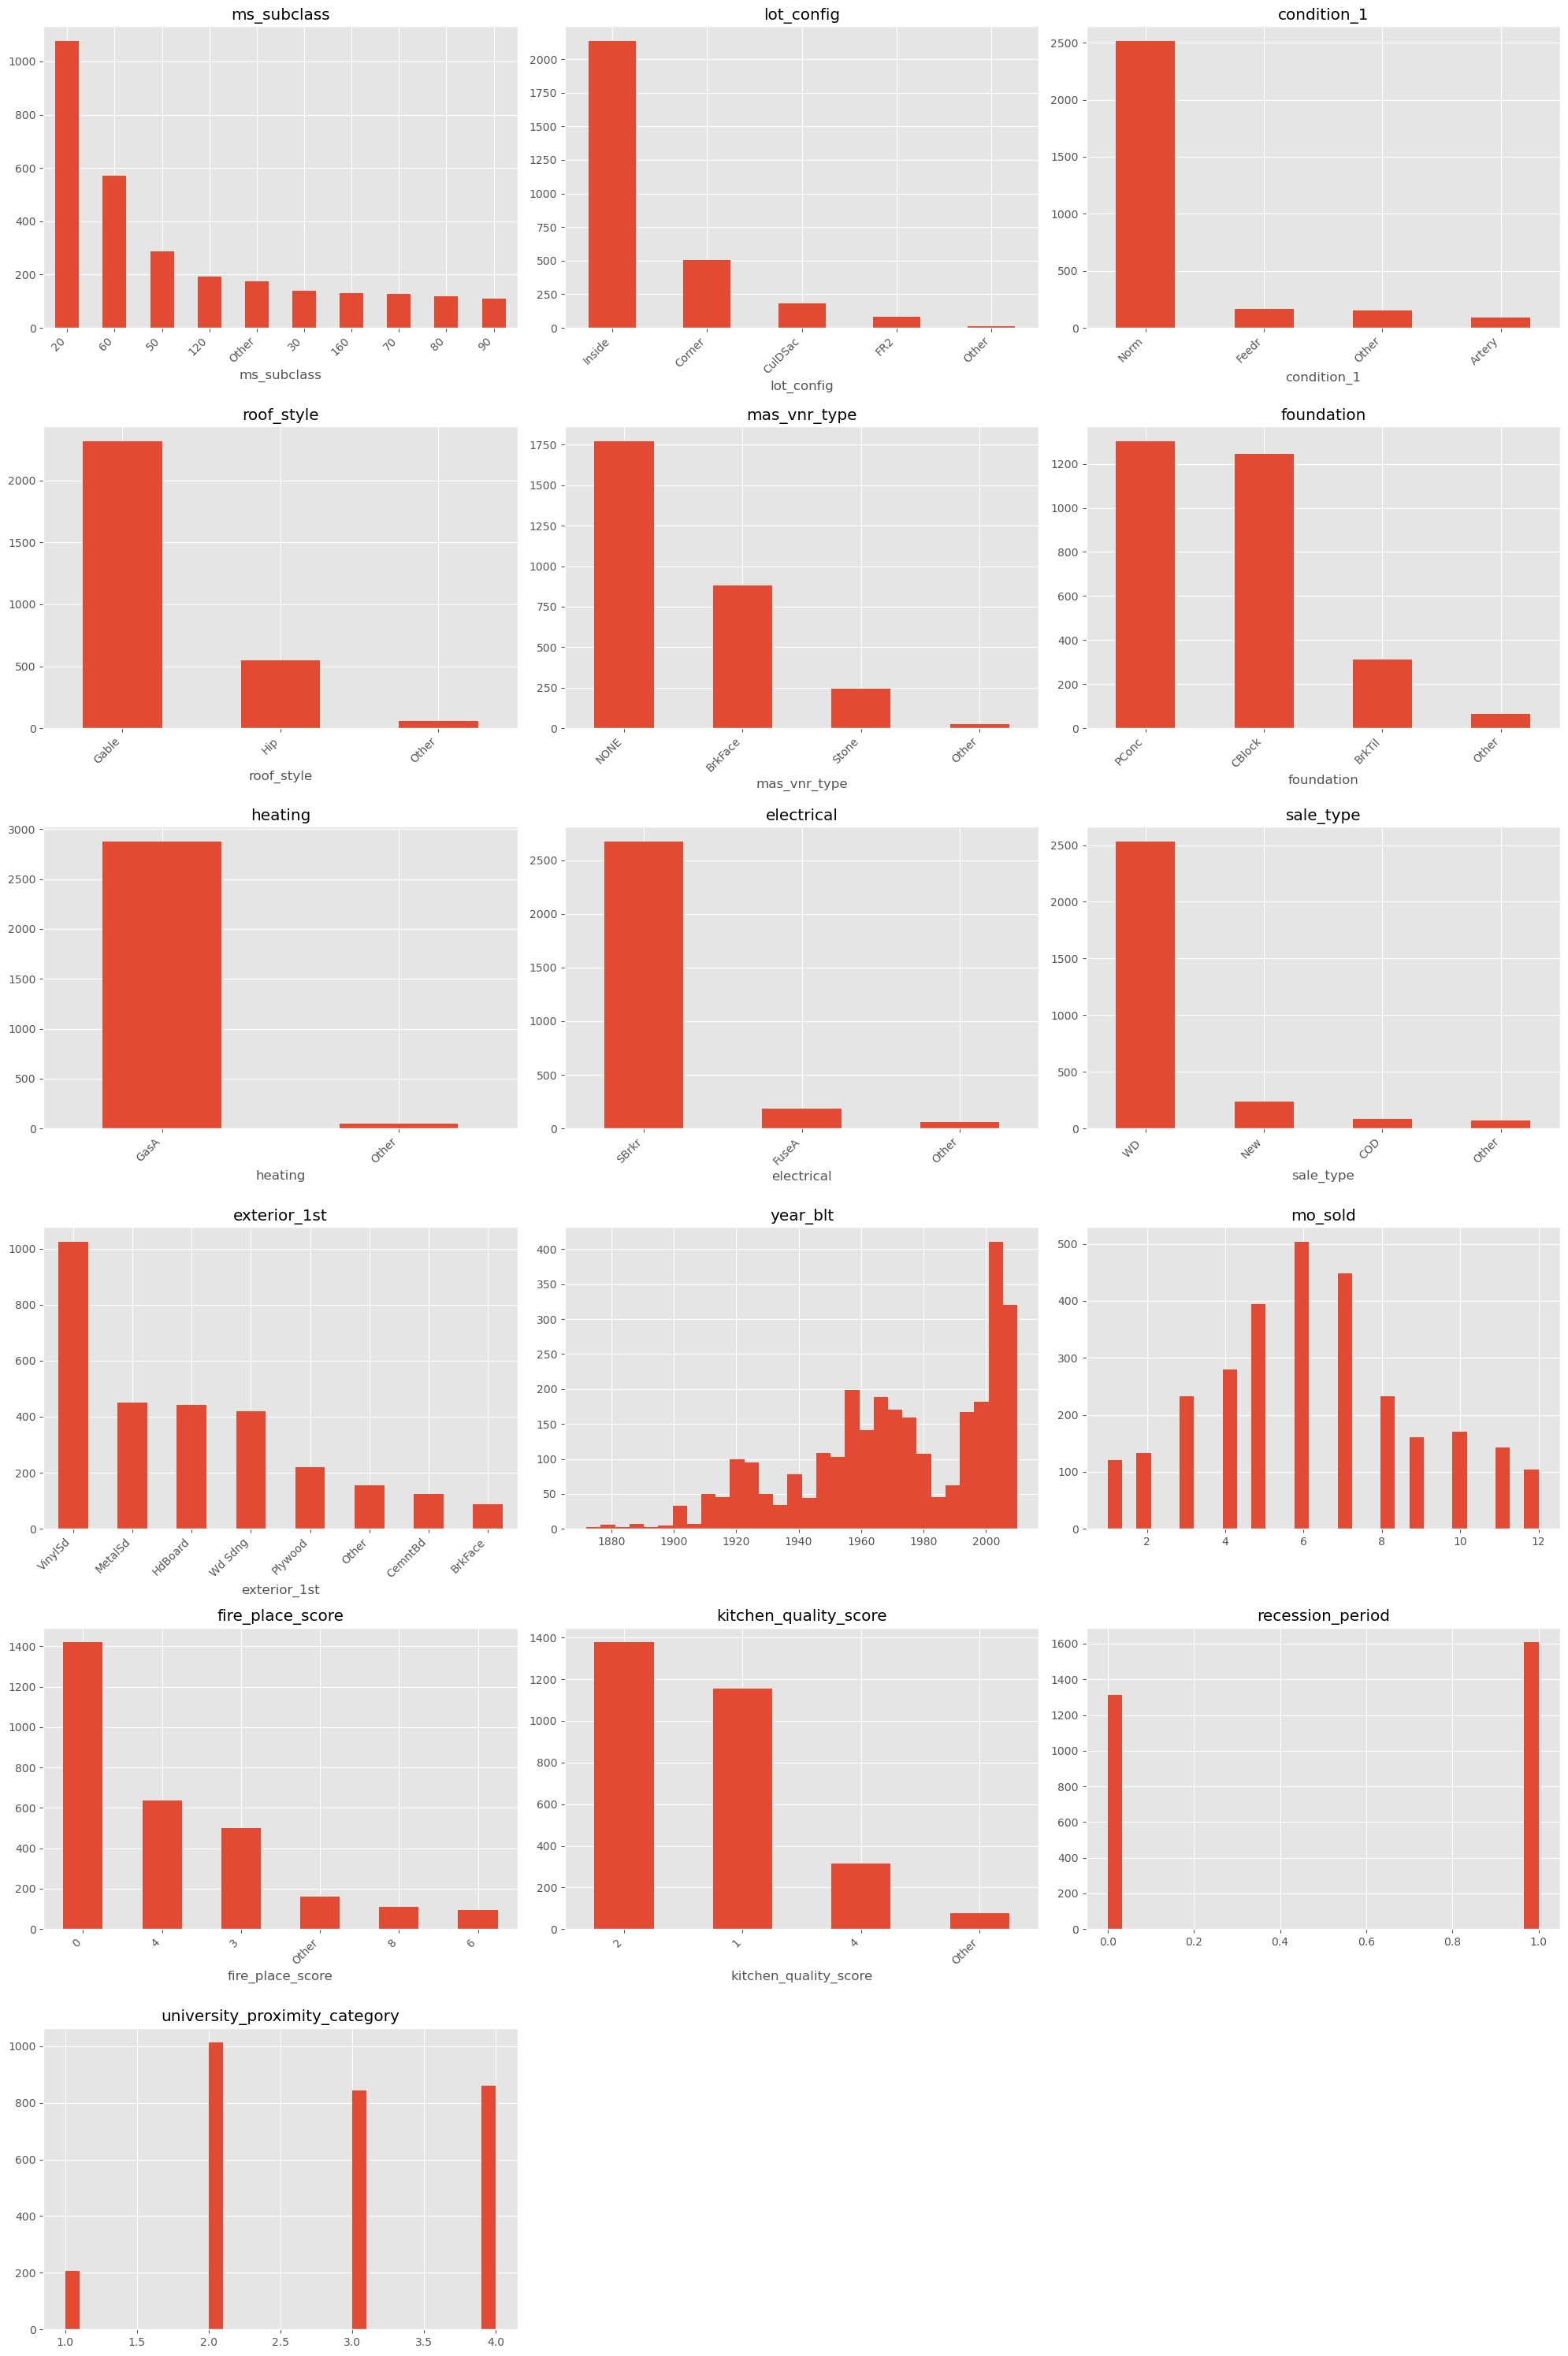

In [297]:
# Create and fit NominalGrouper for nominal features
min_obs = int(0.025 * len(df_transformed))  # 2.5% of data
nominal_grouper = NominalGrouper(min_obs=min_obs)
df_transformed_nominal = df_transformed[final_nominal_features]
df_transformed_nominal_transformed = nominal_grouper.fit_transform(df_transformed_nominal)

# Plot updated distributions
plot_feature_histograms(df_transformed_nominal_transformed)

In [298]:
# Update original dataframe with transformed values
for col in final_nominal_features:
    df_transformed[col] = df_transformed_nominal_transformed[col]

# 3. Numerical Variables YeoJohnson and Scaler 

While the GLM will already potentially capture non-linear relationships, it is still a good idea to apply a YeoJohnson transformation to the numerical variables to mitigate the impact of outliers, while still best extracting the information in the data. 

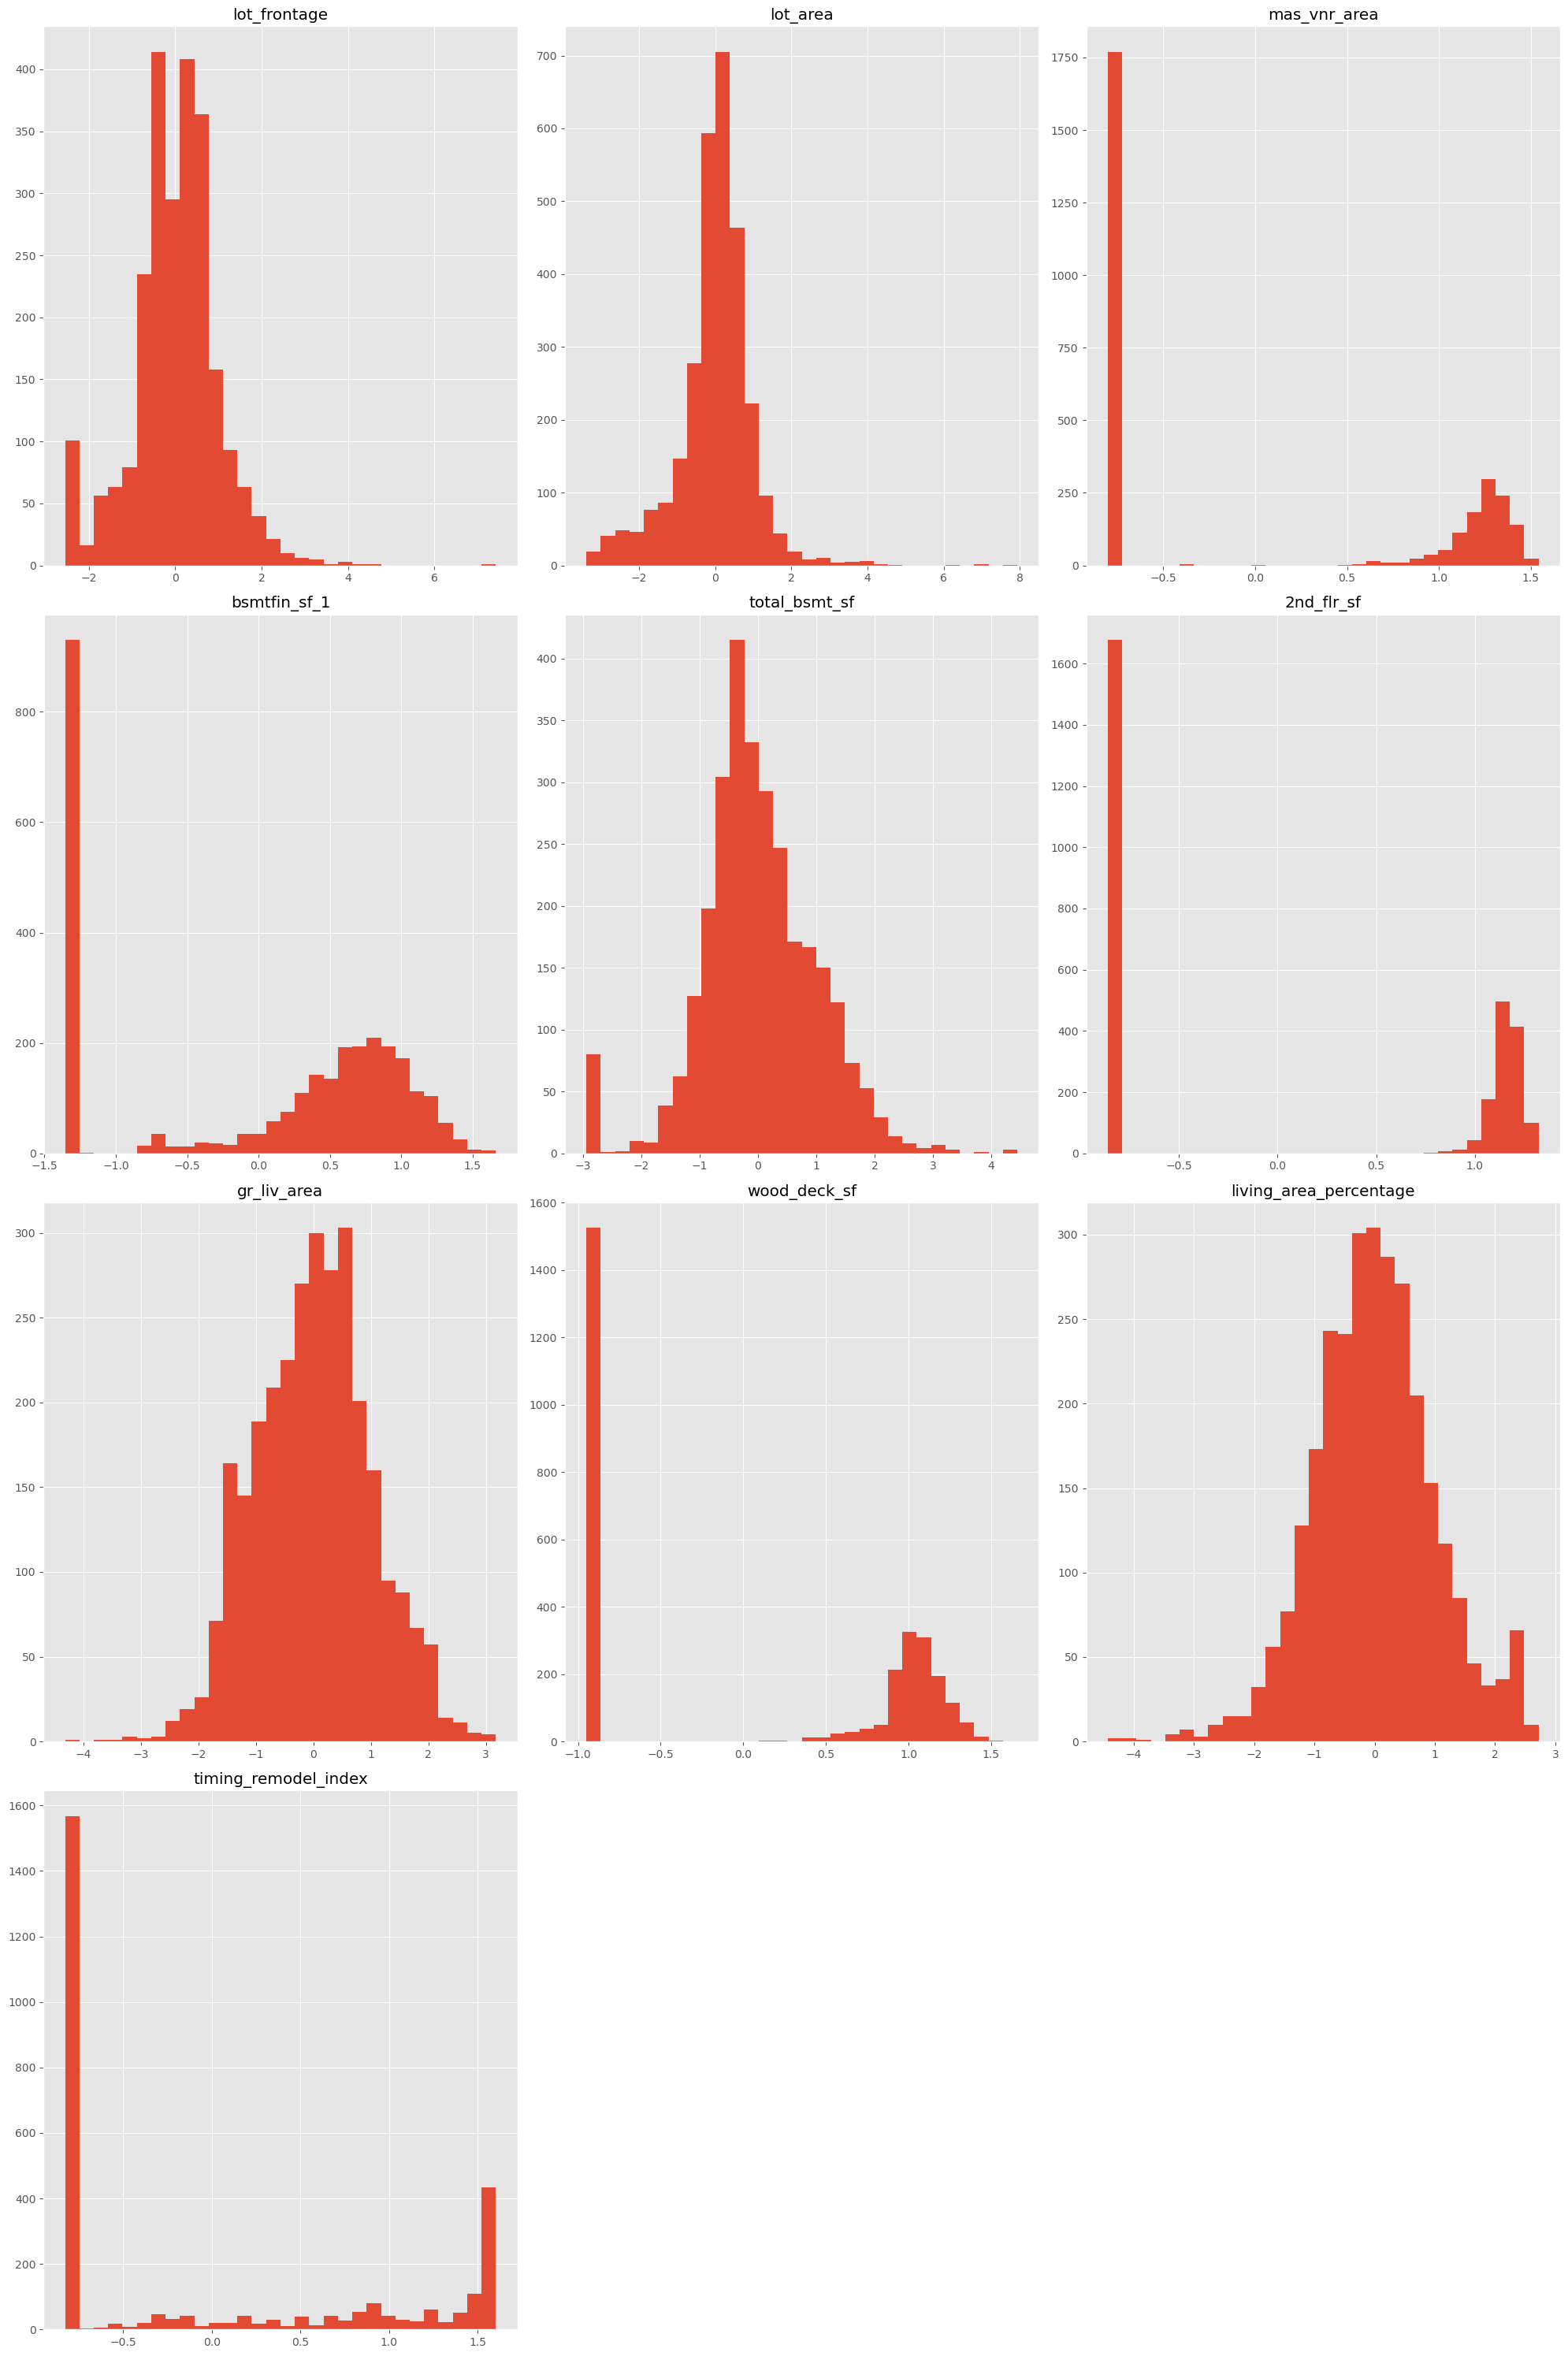

In [299]:
numerical_transformer = NumericalTransformer()
df_numerical = df_transformed[final_continuous_features]
df_numerical_transformed = numerical_transformer.fit_transform(df_numerical)

plot_feature_histograms(df_numerical_transformed)

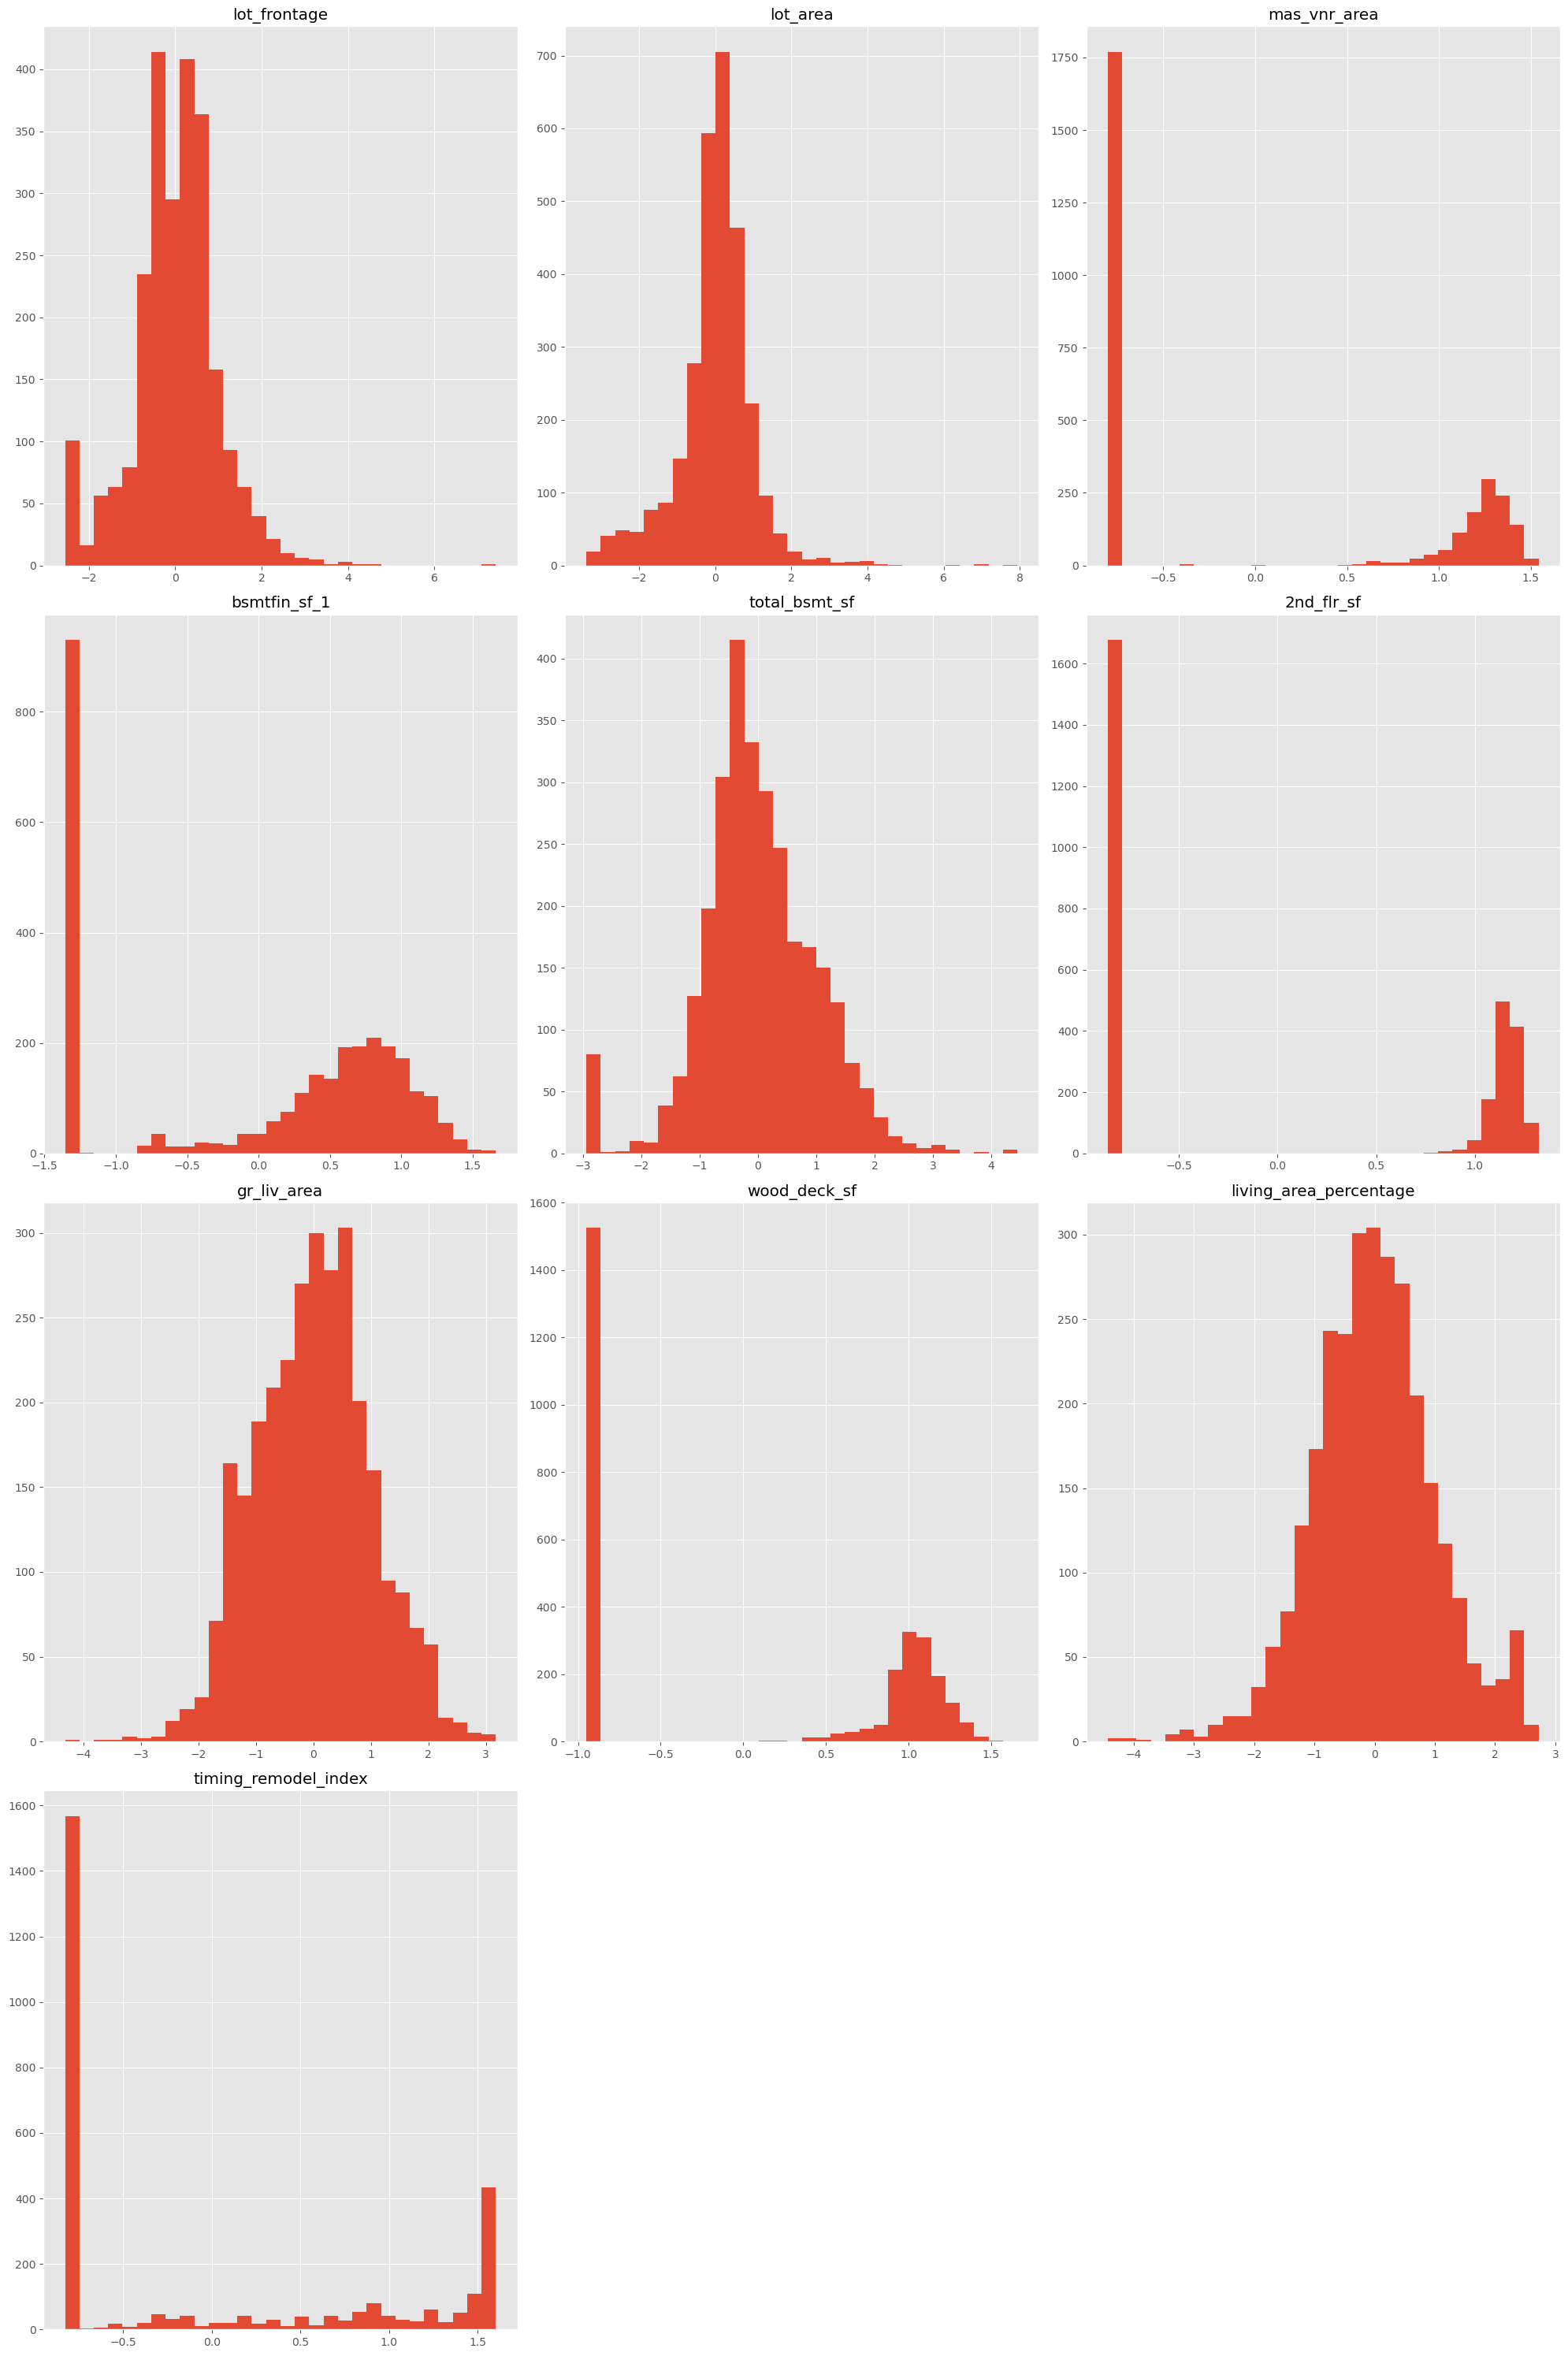

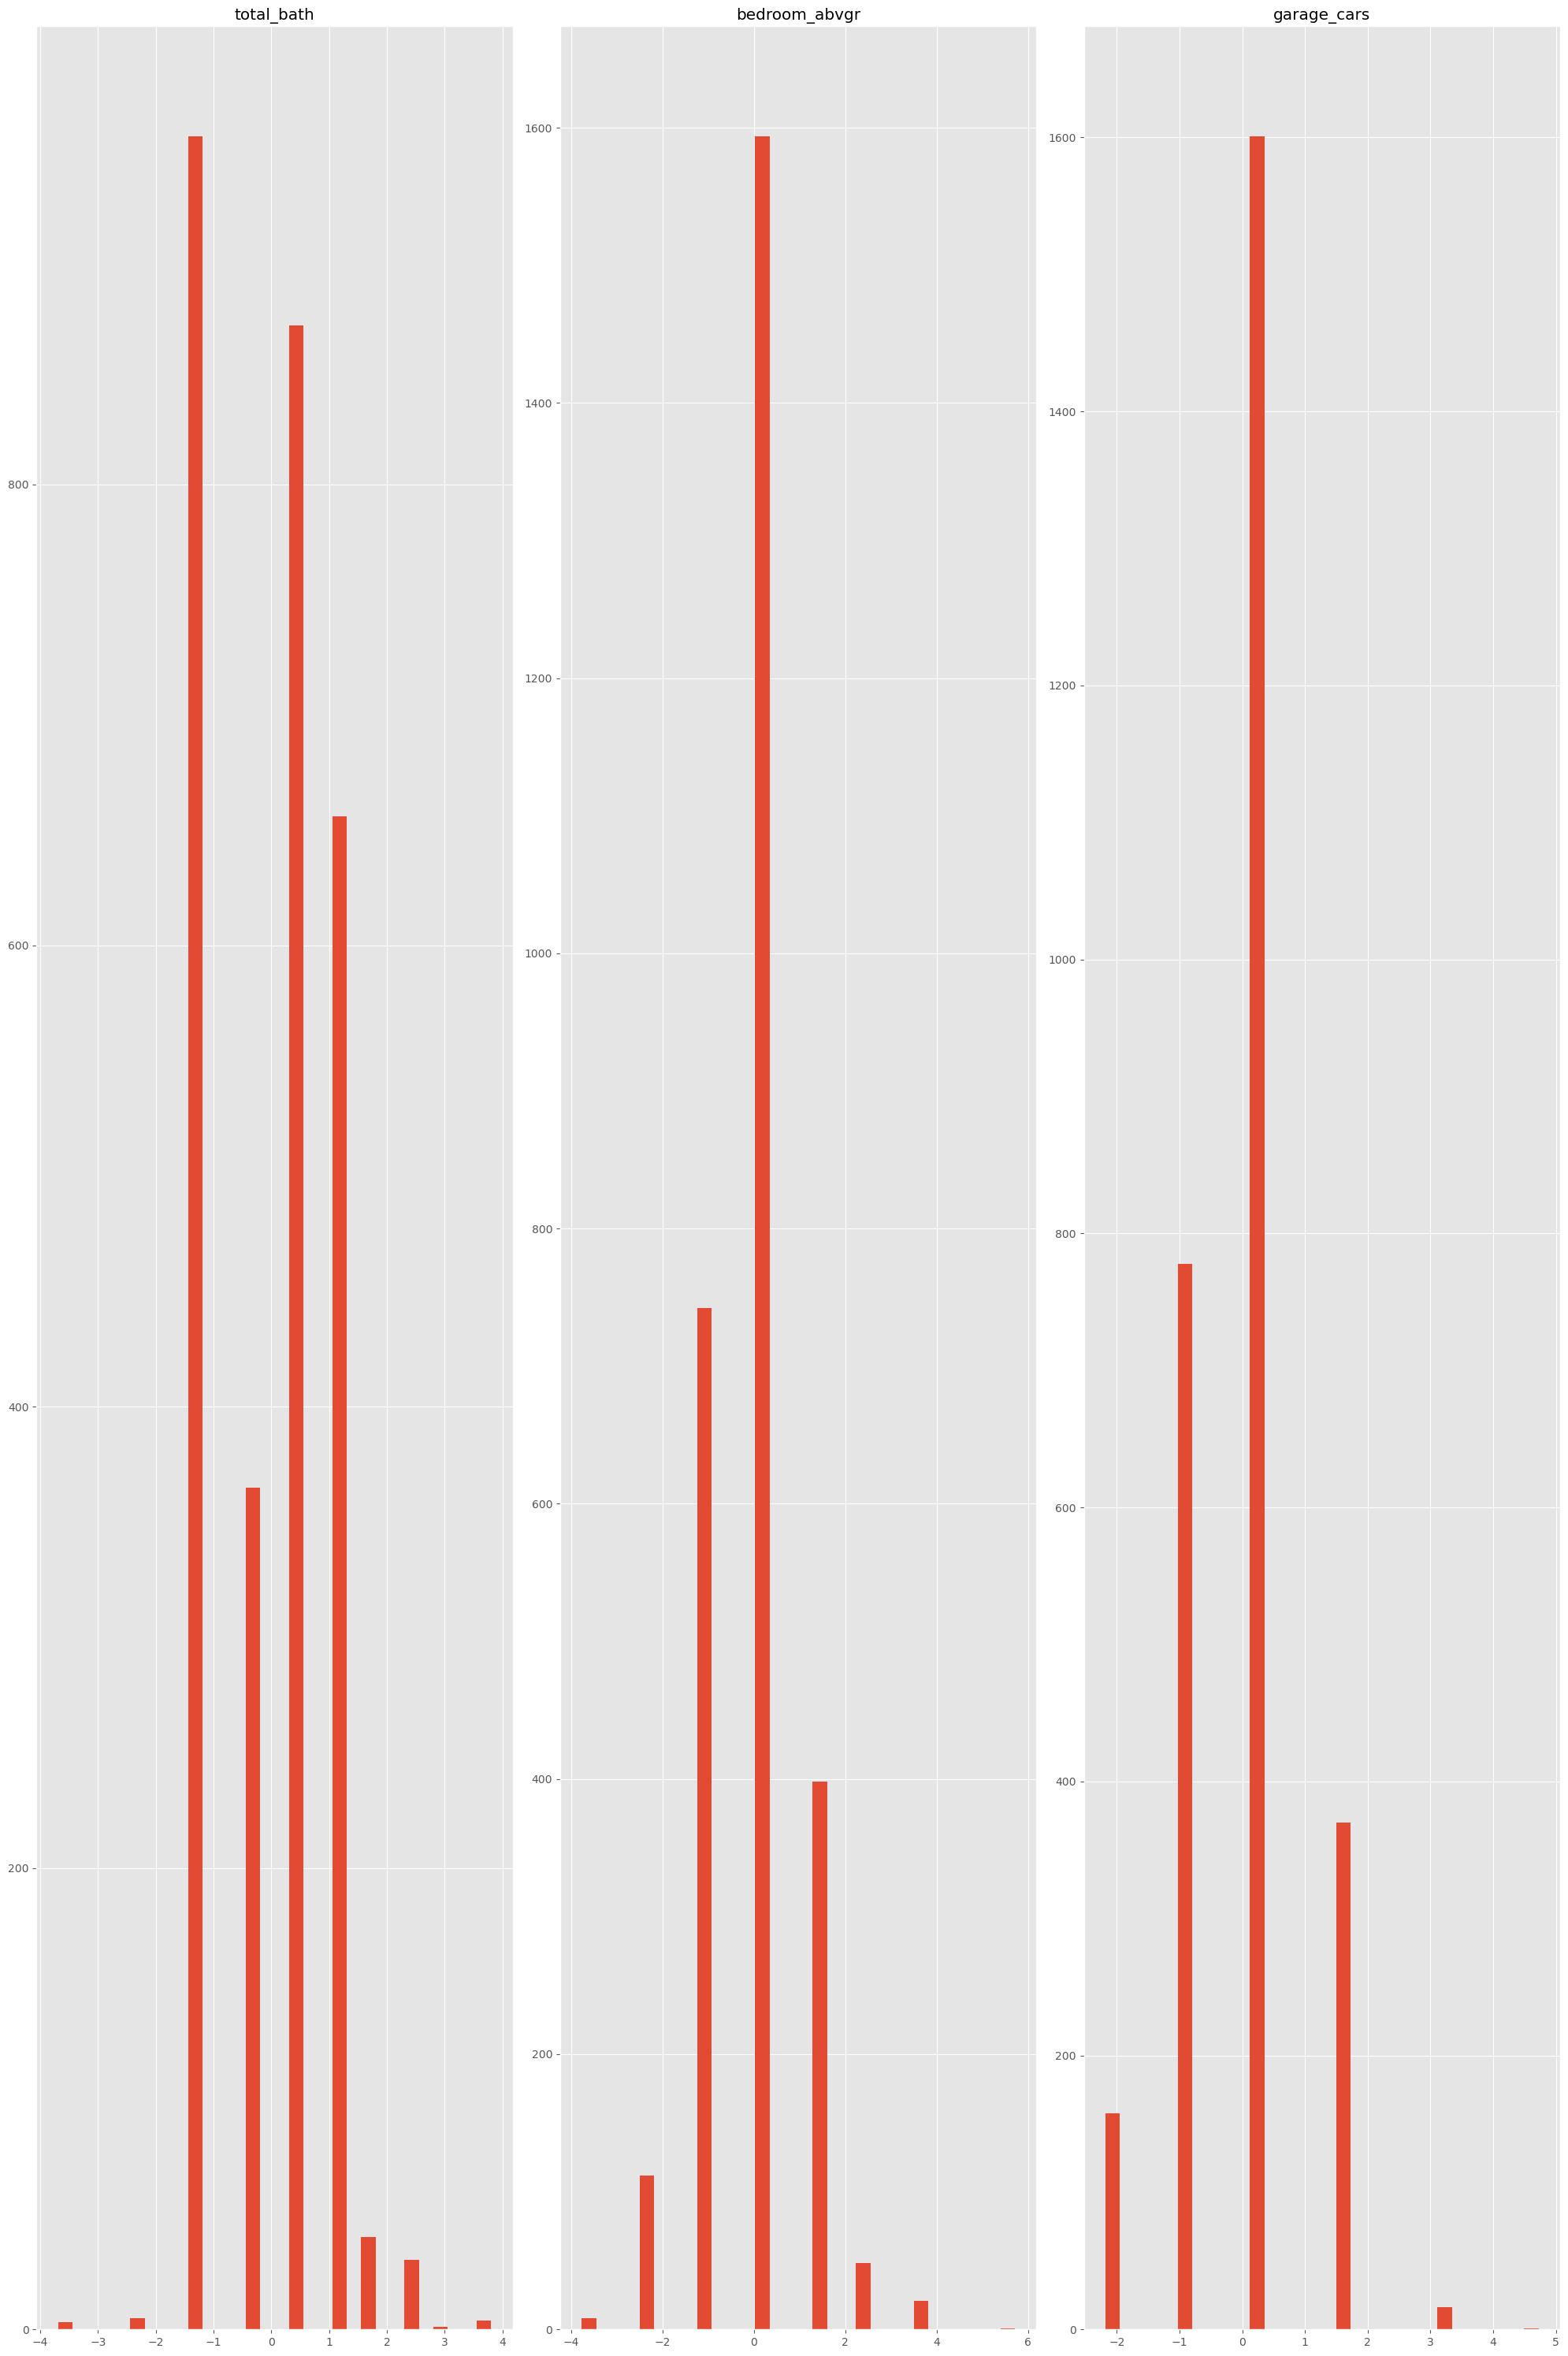

In [300]:
# Transform continuous features
numerical_transformer_continuous = NumericalTransformer()
df_numerical_continuous = df_transformed[final_continuous_features]
df_numerical_continuous_transformed = numerical_transformer_continuous.fit_transform(df_numerical_continuous)

# Transform discrete features 
numerical_transformer_discrete = NumericalTransformer()
df_numerical_discrete = df_transformed[final_discrete_features]
df_numerical_discrete_transformed = numerical_transformer_discrete.fit_transform(df_numerical_discrete)

# Plot transformed distributions
plot_feature_histograms(df_numerical_continuous_transformed)
plot_feature_histograms(df_numerical_discrete_transformed)

# 5. Check interaction terms

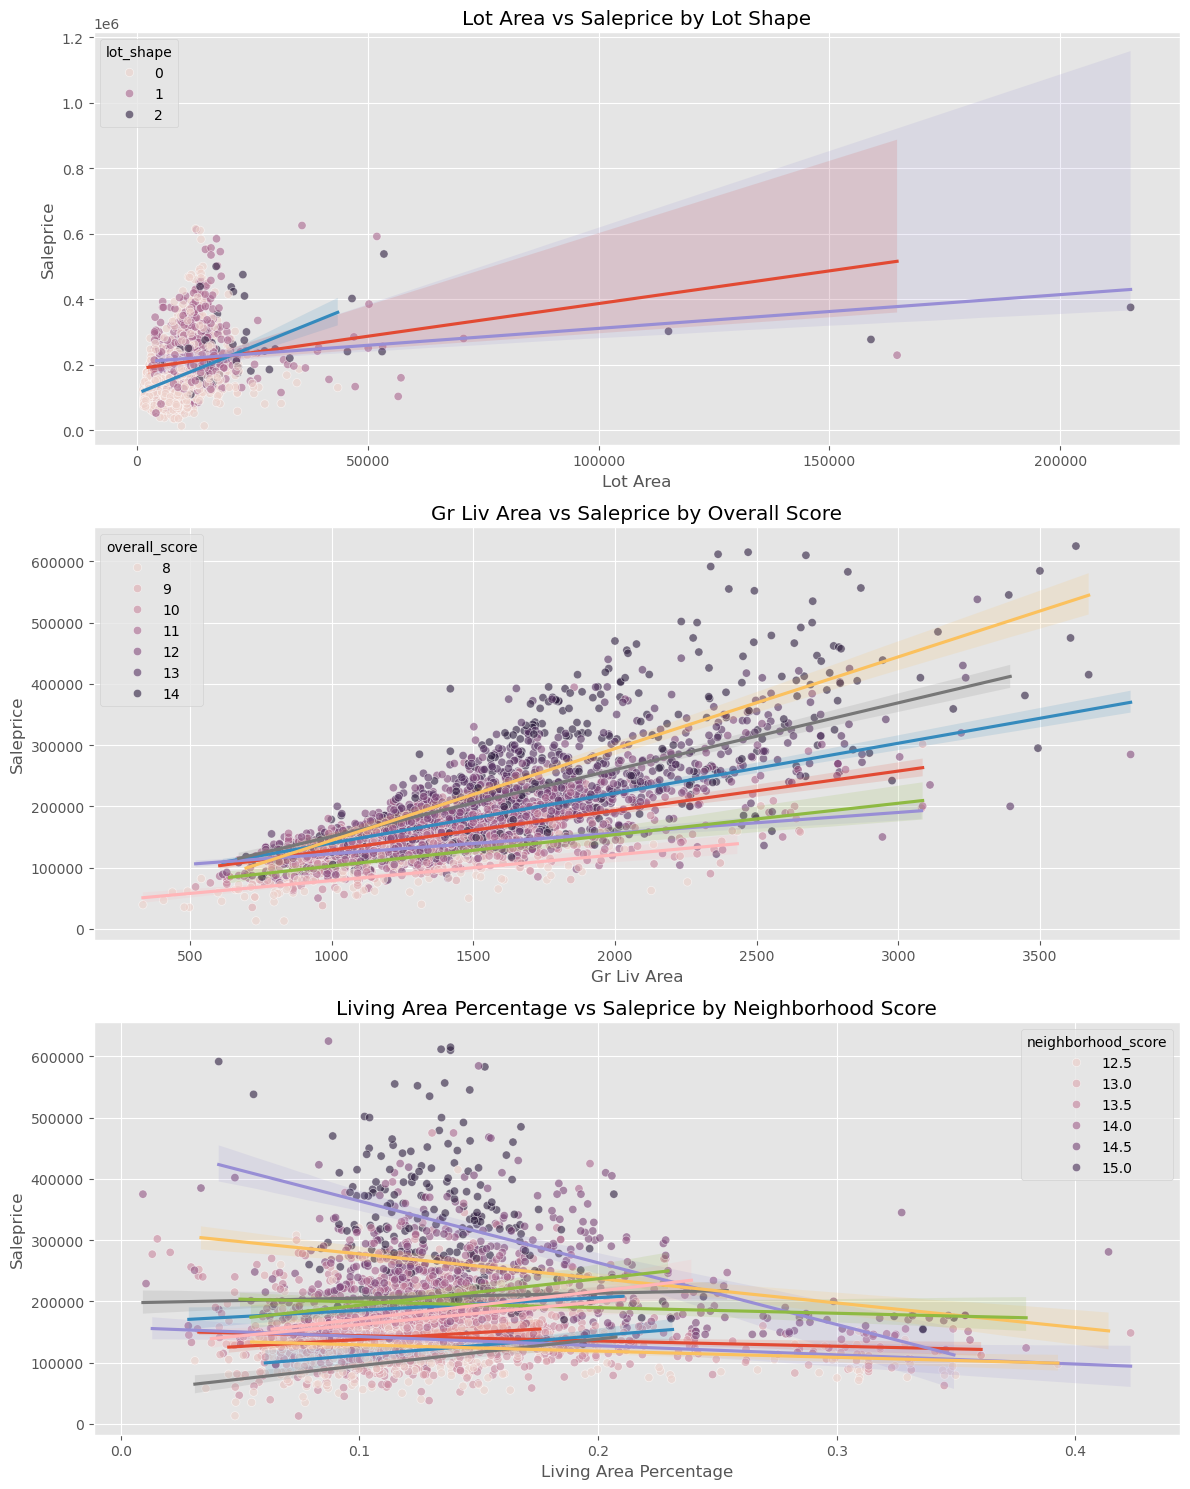

In [301]:
# Define interactions to analyze
interactions_to_plot = [
    ('lot_area', 'saleprice', 'lot_shape'),
    ('gr_liv_area', 'saleprice', 'overall_score'),
    ('living_area_percentage', 'saleprice', 'neighborhood_score')
]

# Create plots
plot_interaction_effects(df_transformed, interactions_to_plot)

